In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import sin
from math import cos
from math import pi
from math import tan
import pandas as pd
from scipy.optimize import curve_fit
from decimal import Decimal
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d


In [2]:
def twoDRocket_ODE(state_vectors, t, g, m, IG, a, alpha, rho, S, Cl,thrust_function,tend,speedofsound):
    # state_vectors = [x, y, V_x, V_y, theta, thetaDot]
    # t             = time vector (s)
    # g             = Gravitational Acceleration m/s^2
    # m             = Mass of the Rocket in kg
    # IG            = Moment of Inertia of the Rocket in kg*m^2
    # a             = Distance between the ceneter of pressure and center of gravity
    # alpha         = Angle of Attack
    # rho           = Air Density
    # S             = Relevant Area for Drag and Lift Force Calculation    
    # Cl            = Lift Coefficient
    # Cd            = Drag Coefficient    
    
    ####################################################
    
    ## Relevant Forces
    # T  = Thrust from Motor in Newtons
    # v  = velocity in body frame or velocity magnitude m/s
    # M  = Mach Number: speed of the object/ speed of the sound in the medium
    # L  = Lift in N (its direction is perpendicular to the veocity vector)
    # D  = Drag in N (its direction is parallel to the velocity vector)
    # Fx = Horizontal force acting on the rocket in body frame in N
    # Fy = Vertical force acting on the rocket in body frame in N
    
    # if t < 0.171:
    #     a = 5.639426
    #     b = 6.81199993
    #     T = a*np.exp(b*t) - 5.63942
    # elif t >= 0.171 and t < 0.191:
    #     a = -22.25
    #     b = 15.94475
    #     T = a*t + b
    # elif t >= 0.191 and t < 0.375:
    #     a = 0.27878129
    #     b = 0.65782577
    #     T = a*np.exp(b/t) + 2.965
    # elif t >= 0.375 and t < 0.746:
    #     a = 12.06731938       
    #     b = -41.5398888
    #     c = 77.00778471
    #     d = -47.47422896 
    #     T =a + b*t + c*t**2 + d*t**3
    # elif t >= 0.746 and t < 0.786:
    #     a = 2.475   
    #     b = 2.37965
    #     T = a*t+b
    # elif t >= 0.786 and t <= 0.86:
    #     a = 273.0396078
    #     b = -600.5275055
    #     c = 329.10706648
    #     T = a + b*t + c*t**2
    # else:
    #     T = 0
    # index = np.where(time == t)[0]
    # print("t: ",t)
    # print("index: ",index)
    # print("type(index.item()): ", type(index))
    if t > tend:
        T = 0
    else:
        T = thrust_function(t)
    v  = math.sqrt(pow(state_vectors[2],2)+pow(state_vectors[3],2))
    M  = v/speedofsound
    
    if M <= 0.6 and M > 0:
        Cd = 0.2083333*pow(M,2) - 0.25*M+0.46
        print(0)
    elif M == 0:
        Cd = 0
        print(1)
    elif M > 0.6 and M <= 0.8:
        Cd = 1.25*pow(M,3) - 2.125*pow(M,2) + 1.2*M + 0.16
    elif M > 0.8 and M <= 0.95:
        Cd = 10.37037*pow(M,3) - 22.88889*pow(M,2) + 16.91111*M - 3.78963
    elif M > 0.95 and M <= 1.05:
        Cd =-30*pow(M,3) + 88.5*pow(M,2) - 85.425*M + 27.51375
        
    L  = 0.5*rho*pow(v,2)*S*Cl
    D  = 0.5*rho*pow(v,2)*S*Cd * np.sign(v)
    Fbh = T + L*sin(alpha) - D*cos(alpha)
    Fbv = L*cos(alpha) + D*sin(alpha)
    
    ####################################################

    ## ODE
    dxdt = state_vectors[2]
    if T == 0 and state_vectors[1] <= 0:
        dydt = 0
    else:
        dydt = state_vectors[3]
    dvxdt = (Fbh*cos(state_vectors[4]) - Fbv*sin(state_vectors[4]))/m
    if state_vectors[1] == 0:
        dvydt = (Fbh*sin(state_vectors[4]) + Fbv*cos(state_vectors[4]) - m*g)/m + g
    else :
        dvydt = (Fbh*sin(state_vectors[4]) + Fbv*cos(state_vectors[4]) - m*g)/m
    dthetadt = state_vectors[5]
    dthetaDotdt = (-L*a*cos(alpha) - D*a*sin(alpha))/IG
    return [dxdt, dydt, dvxdt, dvydt, dthetadt, dthetaDotdt]

In [3]:
## Define Parameters
# state_vectors = [x, y, V_x, V_y, theta, thetaDot]
# x0            = initial states
# tstep         = step size for time vector t in seconds
# t             = time vector (s)
# g             = Gravitational Acceleration m/s^2
# m             = Mass of the Rocket in kg
# IG            = Moment of Inertia of the Rocket in kg*m^2
# a             = Distance between the center of pressure and center of gravity in m
# alpha         = Angle of Attack in radians
# rho           = Air Density in kg/m^3
# S             = Relevant Area for Drag and Lift Force Calculation in m^2  
# Cl            = Lift Coefficient
# Cd            = Drag CoefficiLent   
# cp            = Center of Pressure location from the nose
# cg            = Center of Gravity from the nose
x0    = [0,0,0,0,pi/2,0]
tstep = 0.0001 # s
t     = np.arange(0,7,tstep)
tend  = t[-1]
g     = 9.81 # m/s^2
m     = 0.124 # kg
IG    = 0.007177656 # kg*m^2
cp    = 0.626 # m
cg    = 0.452 # m
a     = abs(cp-cg)
alpha = 0
rho   = 1.130568 # kg/m^3 for Allen on 7/30/2025 at about 3:53 pm
S     = 1/4*pi*pow(0.035,2) # m^2
Cl    = 16.85 * alpha
gamma = 1.4
R     = 286
T     = 273.15 + 37.2222 # converting celsius to kelvin
speedofsound =np.sqrt(gamma*R*T)
print('Speed of Sound:',speedofsound, 'm/s')

Speed of Sound: 352.52379902639194 m/s


In [4]:
## Thrust Curve
ThrustData = pd.read_csv(r'C:\Users\bktf3\Desktop\rocket\simulation\B6motorThrustDatabyJohnCoker.csv', skiprows=3)
ThrustData.set_index('Time (s)')
# ThrustData.plot.scatter(title = 'B6 Motor Thrust Curve by John Coker', x = 'Time (s)', y = 'Thrust (N)', xlabel = ('Time (s)'), ylabel = ('Thrust (N)')) 

,Thrust (N)
Time (s),
0.000,0.000
0.023,0.688
0.057,2.457
0.089,4.816
0.116,7.274
0.148,9.929
0.171,12.140
0.191,11.695
0.200,10.719


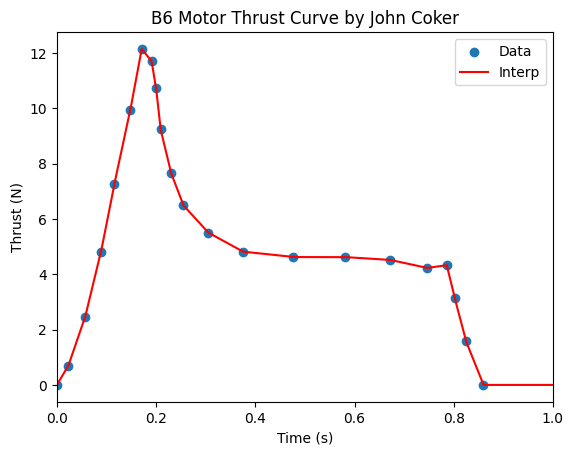

In [5]:
## Curve Fit Thrust Curve
ThrustData = pd.DataFrame(ThrustData).to_numpy()
fit = []
fit = np.interp(t, ThrustData[:,0],ThrustData[:,1])
# Type of curve I am going to be fitting for the thrust curve
# def linear(x, a,b):
#     return a*x + b  
# for i in range(0,len(ThrustData)-1):
#     timeForCurveFit = np.arange(ThrustData[i,0],ThrustData[i+1,0]+tstep,tstep)
#     constants       = curve_fit(linear, ThrustData[i:i+2,0], ThrustData[i:i+2,1])
#     a = constants[0][0]
#     b = constants[0][1]
#     for j in timeForCurveFit:
#         fit.append(linear(j, a,b))
#         curvetime.append(j)
# fit = np.array(fit)
# curvetime = np.array(curvetime)

plt.scatter(ThrustData[:,0],ThrustData[:,1])
plt.plot(t,fit, color ='red')
plt.title('B6 Motor Thrust Curve by John Coker')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.xlim([0,1])
plt.legend(['Data','Interp'])

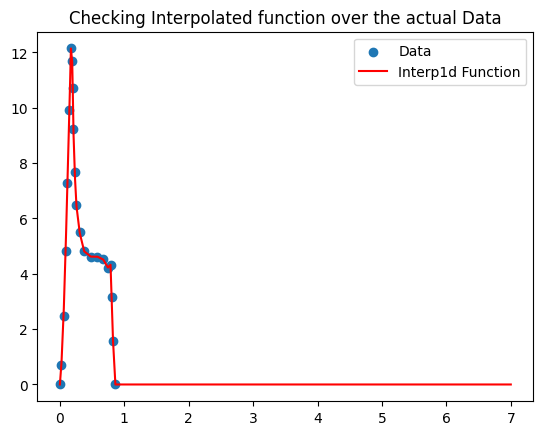

In [6]:
thrust_function = interp1d(t,fit)
type(thrust_function)
plt.scatter(ThrustData[:,0],ThrustData[:,1])
plt.plot(t,thrust_function(t),color="red")
plt.title('Checking Interpolated function over the actual Data')
# plt.xlim([0,1])
plt.legend(['Data','Interp1d Function'])

In [7]:
# ## Second attempt at fitting Thrust Curve to be used in the ODE
# def func(x, a, b):
#     return a*np.exp(b*x)-5.63942
# popt, pcov = curve_fit(func,ThrustData[0:7,0],ThrustData[0:7,1])
# print(popt)
# timeForCurveFit = np.arange(ThrustData[0,0],ThrustData[6,0]+tstep,tstep)
# y =func(timeForCurveFit,*popt)
# plt.scatter(ThrustData[0:7,0],ThrustData[0:7,1])
# plt.plot(timeForCurveFit,y,'r')
# print(ThrustData[0:7,0])
# print(timeForCurveFit)
# print(ThrustData[6,0])
# print(y[0])
# plt.title('Curve fit for Seconds 0 to 0.171')
# plt.legend(['Experiment', 'Curve Fit'])
# plt.xlabel('Time (s)')
# plt.ylabel('Newton (N)')

In [8]:
# ## Second attempt at fitting Thrust Curve to be used in the ODE
# def func(x, a, b):
#     return a*x+b
# popt, pcov = curve_fit(func,ThrustData[6:8,0],ThrustData[6:8,1])
# print(popt)
# timeForCurveFit = np.arange(ThrustData[6,0],ThrustData[7,0]+tstep,tstep)
# y =func(timeForCurveFit,*popt)
# plt.scatter(ThrustData[6:8,0],ThrustData[6:8,1])
# plt.plot(timeForCurveFit,y,'r')
# # print(ThrustData[0:7,0])
# # print(timeForCurveFit)
# print(timeForCurveFit[-1])
# print(ThrustData[7,0])
# plt.title('Curve fit for Seconds 0.171 to 0.191')
# plt.legend(['Experiment', 'Curve Fit'])
# plt.xlabel('Time (s)')
# plt.ylabel('Newton (N)')

In [9]:
# def func(x, a, b):
#     return a*np.exp(b/x)+2.965
# popt, pcov = curve_fit(func,ThrustData[7:14,0],ThrustData[7:14,1])
# print(popt)
# timeForCurveFit = np.arange(ThrustData[7,0],ThrustData[13,0]+tstep,tstep)
# y =func(timeForCurveFit,*popt)
# plt.scatter(ThrustData[7:14,0],ThrustData[7:14,1])
# plt.plot(timeForCurveFit,y,'r')
# print(ThrustData[7:14,0])
# print(timeForCurveFit[-1])
# print(ThrustData[13,0])
# print(y[0])
# plt.title('Curve fit for Seconds 0.191 to 0.375')
# plt.legend(['Experiment', 'Curve Fit'])
# plt.xlabel('Time (s)')
# plt.ylabel('Newton (N)')

In [10]:
# def func(x, a, b,c,d):
#     return a+b*x+c*x**2+d*x**3
# popt, pcov = curve_fit(func,ThrustData[13:18,0],ThrustData[13:18,1])
# print(popt)
# timeForCurveFit = np.arange(ThrustData[13,0],ThrustData[17,0]+tstep,tstep)
# y =func(timeForCurveFit,*popt)
# plt.scatter(ThrustData[13:18,0],ThrustData[13:18,1])
# plt.plot(timeForCurveFit,y,'r')
# print(ThrustData[13:18,0])
# print(timeForCurveFit[-1])
# print(ThrustData[17,0])
# print(y[0])
# plt.title('Curve fit for Seconds 0.375 to 0.746')
# plt.legend(['Experiment', 'Curve Fit'])
# plt.xlabel('Time (s)')
# plt.ylabel('Newton (N)')

In [11]:
# def func(x, a, b):
#     return a*x+b
# popt, pcov = curve_fit(func,ThrustData[17:19,0],ThrustData[17:19,1])
# print(popt)
# timeForCurveFit = np.arange(ThrustData[17,0],ThrustData[18,0]+tstep,tstep)
# y =func(timeForCurveFit,*popt)
# plt.scatter(ThrustData[17:19,0],ThrustData[17:19,1])
# plt.plot(timeForCurveFit,y,'r')
# print(ThrustData[17:19,0])
# print(timeForCurveFit[-1])
# print(ThrustData[18,0])
# print(y[0])
# plt.title('Curve fit for Seconds 0.746 to 0.786')
# plt.legend(['Experiment', 'Curve Fit'])
# plt.xlabel('Time (s)')
# plt.ylabel('Newton (N)')

In [12]:
# def func(x, a, b,c):
#     return a + b*x + c*x**2
# popt, pcov = curve_fit(func,ThrustData[18:22,0],ThrustData[18:22,1])
# print(popt)
# timeForCurveFit = np.arange(ThrustData[18,0],ThrustData[21,0]+tstep,tstep)
# y =func(timeForCurveFit,*popt)
# plt.scatter(ThrustData[18:22,0],ThrustData[18:22,1])
# plt.plot(timeForCurveFit,y,'r')
# print(ThrustData[18:22,0])
# print(timeForCurveFit[-1])
# print(ThrustData[21,0])
# print(y[0])
# plt.title('Curve fit for Seconds 0.786 to 0.86')
# plt.legend(['Experiment', 'Curve Fit'])
# plt.xlabel('Time (s)')
# plt.ylabel('Newton (N)')

In [13]:
solution = odeint(twoDRocket_ODE, x0, t, args = (g, m, IG, a, alpha, rho, S, Cl, thrust_function,tend,speedofsound))

1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Text(0, 0.5, 'Distance (m)')

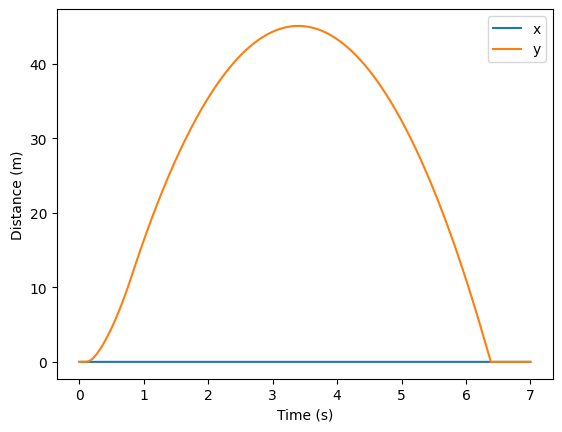

In [14]:
plt.plot(t, solution[:,0])
plt.plot(t, solution[:,1])
plt.legend(['x','y'])
# plt.xlabel('x(m)')
# plt.ylabel('y (m)')
# plt.xlim(0,0.1)
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')

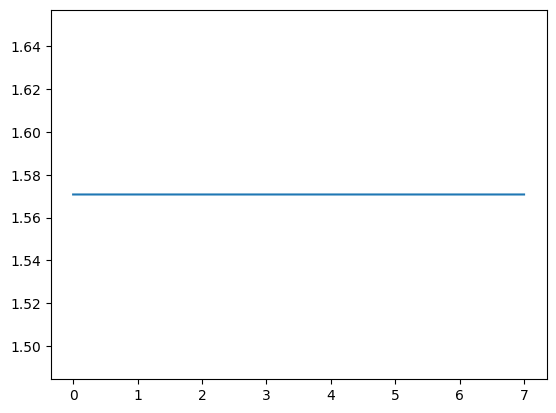

In [15]:
plt.plot(t,solution[:,4])
# plt.legend(['Vx'])

Text(0.5, 1.0, 'Simulated Vertical Speed (Vy) of Rocket')

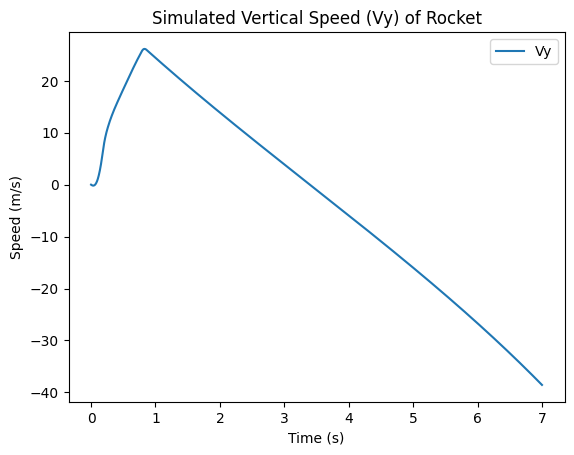

In [16]:
plt.plot(t,solution[:,3])
plt.legend(['Vy'])
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Simulated Vertical Speed (Vy) of Rocket')

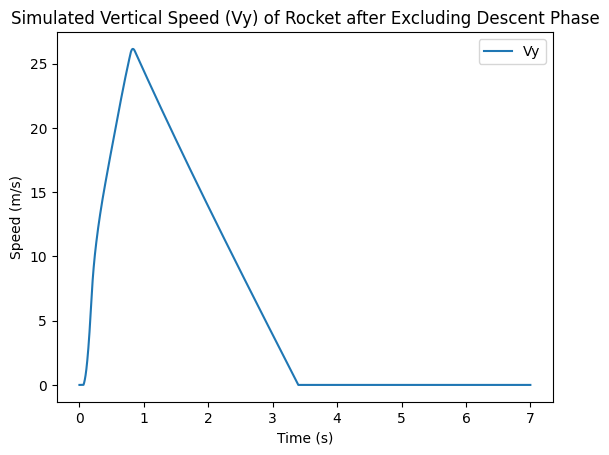

In [17]:
descentExcludedSpeed = []

for j in solution[:,3]:
    if j > 0:
        descentExcludedSpeed.append(j)
    else:
        descentExcludedSpeed.append(0)
plt.plot(t,descentExcludedSpeed)
plt.title('Simulated Vertical Speed (Vy) of Rocket after Excluding Descent Phase')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend(['Vy'])

In [18]:
# plt.plot(t,solution[:,5])

In [19]:
# ## Check Thrust
# check =[]
# for j in t:
#     if j < 0.171:
#         a = 5.639426
#         b = 6.81199993
#         T = a*np.exp(b*j) - 5.63942
#         check.append(T)
#     elif j >= 0.171 and j < 0.191:
#         a = -22.25
#         b = 15.94475
#         T = a*j + b
#         check.append(T)
#     elif j >= 0.191 and j < 0.375:
#         a = 0.27878129
#         b = 0.65782577
#         T = a*np.exp(b/j) + 2.965
#         check.append(T)
#     elif j >= 0.375 and j < 0.746:
#         a = 12.06731938       
#         b = -41.5398888
#         c = 77.00778471
#         d = -47.47422896 
#         T =a + b*j + c*j**2 + d*j**3
#         check.append(T)
#     elif j >= 0.746 and j < 0.786:
#         a = 2.475   
#         b = 2.37965
#         T = a*j+b
#         check.append(T)
#     elif j >= 0.786 and j <= 0.86:
#         a = 273.0396078
#         b = -600.5275055
#         c = 329.10706648
#         T = a + b*j + c*j**2
#         check.append(T)
#     else:
#         T = 0
#         check.append(T)


In [20]:
# plt.plot(t,check, color = 'red')
# plt.scatter(ThrustData[:,0],ThrustData[:,1])
# plt.xlim(0,1)
# plt.legend(['Interporlated', 'Actual Data'])

#############################################################################################################################
## SUMMARY for the Black Rocket

In [22]:
print('Maximum Height: ', round(max(solution[:,1]),2), 'm') 
speed = np.sqrt(pow(solution[:,2],2)+pow(solution[:,3],2))
print('Maximum Speed: ', round(max(descentExcludedSpeed),2), 'm/s', 'or',  round(max(speed)/1000*60*60,2), 'km/h')
# np.where(solution[:,1] < 0)[0]
print('Duration: ','--', 's')
print('Thurst Time: ', ThrustData[-1,0], 's')
ApogeeTime = t[np.where(solution[:,1] == max(solution[:,1]))[0]]
print('Coast to Apogee: ', ApogeeTime-ThrustData[-1,0], 's')

Maximum Height:  45.07 m
Maximum Speed:  26.14 m/s or 138.83 km/h
Duration:  -- s
Thurst Time:  0.86 s
Coast to Apogee:  [2.5373] s


In [23]:
# np.where(solution[:,1] < 0)[0]
# np.where(solution[:,1] == max(solution[:,1]))[0]
# print(np.where(solution[:,1] == max(solution[:,1]))[0])
# print(solution[np.where(solution[:,1] == max(solution[:,1]))[0],1])
# print(t[np.where(solution[:,1] == max(solution[:,1]))[0]])

#############################################################################################################################
## 3rd Rocket Flight Results 7/30/2025 ("Flight #1")

In [25]:
print('Maximum Height: ', 45, 'm') 
print('Maximum Speed: ', 27, 'm/s', 'or',  round(27/1000*60*60,2), 'km/h')
# print('Duration: ', 9.6, 's')
print('Thurst Time: ', 0.88, 's')
print('Coast to Apogee: ', 2.6, 's')

Maximum Height:  45 m
Maximum Speed:  27 m/s or 97.2 km/h
Duration:  9.6 s
Thurst Time:  0.88 s
Coast to Apogee:  2.6 s
